# 0. Preprocesiranje i ucitavanje biblioteka 

In [1]:
!pip list

Package                      Version
---------------------------- --------------
absl-py                      2.1.0
anyio                        4.3.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.2.0
Babel                        2.14.0
beautifulsoup4               4.12.3
bleach                       6.1.0
certifi                      2024.2.2
cffi                         1.16.0
charset-normalizer           3.3.2
cmake                        3.29.2
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.2.0
cycler                       0.12.1
debugpy                      1.8.1
decorator                    5.1.1
defusedxml                   0.7.1
dlib                         19.24.4
executing                    2.0.1
fastjsonschema               2.

In [2]:
#pip  install --user --upgrade pip
#pip install --upgrade --user pip setuptools
#!pip install opencv-python matplotlib imageio gdown tensorflow

In [3]:
tf.config.list_physical_devices('GPU')

NameError: name 'tf' is not defined

In [ ]:
import os
import gdown
import cv2
import dlib
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
from tensorflow.python.client import device_lib

In [ ]:
#vraca graficke karte na racunaru
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

#print(get_available_devices())

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('NO GPU')
    pass

# 1. Ucitavanje podataka

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

In [8]:
def load_video(path:str, width: int = 64, height: int = 64) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []

  
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")


    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        
        
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
       
        faces = detector(gray_frame)
        
        for face in faces:

            #nalazimo lice na slici(frejmu) i obelezavamo tacke koje oznacavaju usne
            #secemo sliku 64x64 oko usana i takav frejm ubacujemo u neuralnu mrezu
            
            landmarks = predictor(gray_frame, face)
            
        
            lip_left = landmarks.part(48).x
            lip_right = landmarks.part(54).x
            lip_top = min(landmarks.part(50).y, landmarks.part(51).y)
            lip_bottom = max(landmarks.part(58).y, landmarks.part(59).y)

          
            lip_frame = frame[lip_top:lip_bottom, lip_left:lip_right]
            
            
            lip_frame_resized = cv2.resize(lip_frame, (width, height))  
            #resajzujemo sliku oko usta na 64x64
            
           
            lip_frame_gray = cv2.cvtColor(lip_frame_resized, cv2.COLOR_BGR2GRAY)
            
            
            frames.append(lip_frame_gray)

    cap.release()

    # Convert frames to tensor
    frames = tf.convert_to_tensor(frames, dtype=tf.float32) #pretvaramo u tensor da bi mogli da koristimo u NN

    #standardizujemo sliku
    mean = tf.reduce_mean(frames)
    std = tf.math.reduce_std(frames)

    return tf.cast((frames - mean), tf.float32) / std

In [9]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [10]:
#################################
# tokenizujemo sve karaktere da budu oznaceni sa jedinstvenim brojem
# num_to_char da vratimo oznake iz broja u karakter da bi mogli da impretiramo yhat
#####################################

char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [11]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [12]:
char_to_num(['d','r','a','g','o','m','i','r'])

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([ 4, 18,  1,  7, 15, 13,  9, 18], dtype=int64)>

In [13]:
num_to_char([ 4, 18,  1,  7, 15, 13,  9, 18])

<tf.Tensor: shape=(8,), dtype=string, numpy=array([b'd', b'r', b'a', b'g', b'o', b'm', b'i', b'r'], dtype=object)>

In [14]:
# funkcija load_aligments ucitava ground truth labels svakog od videa u bazi

def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [15]:
# funkcija load_data ucitava aligments(labele), 
# ucitava video i izdvaja automatski usne na video snimku

def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [16]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [17]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [18]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [19]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

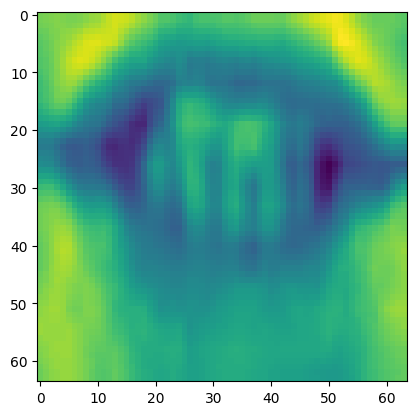

In [20]:
plt.imshow(frames[35])

In [21]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [22]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [23]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [24]:
frames.shape

TensorShape([75, 64, 64])

# 2. pravljenje PipeLine za podatke

In [25]:
from matplotlib import pyplot as plt

In [26]:
#videe iz baze podataka stavljamo u promenjivu data 
data = tf.data.Dataset.list_files('./data/s1/*.mpg')

#meša redosled datoteka (do 500 datoteka) bez ponovnog mešanja pri svakoj iteraciji
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)

# grupise podatke u batcheve veličine 2 i vrši padding na dimenzije ([75,64,64],[40])
data = data.padded_batch(2, padded_shapes=([75,64,64],[40])) 

# prefetching za optimizaciju performansi (učitava podatke unapred asinhrono)
data = data.prefetch(tf.data.AUTOTUNE)

#train je prvih 450 videa
train = data.take(450)

#test je poslednjih 50 videa
test = data.skip(450)

In [27]:
len(data)

500

In [28]:
len(test)

50

In [29]:
frames, alignments = data.as_numpy_iterator().next()

In [30]:
len(frames)

2

In [31]:
sample = data.as_numpy_iterator()

In [32]:
val = sample.next(); val[0]

array([[[[1.2083519 , 1.2531248 , 1.3426707 , ..., 1.5665355 ,
          1.4322166 , 1.3426707 ],
         [1.2083519 , 1.2531248 , 1.3426707 , ..., 1.5665355 ,
          1.4322166 , 1.3426707 ],
         [1.2083519 , 1.2531248 , 1.3426707 , ..., 1.5665355 ,
          1.4322166 , 1.3426707 ],
         ...,
         [1.4322166 , 1.3874437 , 1.3426707 , ..., 1.2531248 ,
          1.2083519 , 1.2083519 ],
         [1.4322166 , 1.3874437 , 1.3426707 , ..., 1.2531248 ,
          1.2083519 , 1.2083519 ],
         [1.4322166 , 1.3874437 , 1.3426707 , ..., 1.2531248 ,
          1.2083519 , 1.2083519 ]],

        [[1.4322166 , 1.4322166 , 1.4322166 , ..., 1.2531248 ,
          1.2083519 , 1.1635789 ],
         [1.4322166 , 1.4322166 , 1.4322166 , ..., 1.2531248 ,
          1.2083519 , 1.1635789 ],
         [1.4322166 , 1.4322166 , 1.4322166 , ..., 1.2531248 ,
          1.2083519 , 1.1635789 ],
         ...,
         [1.4769895 , 1.4769895 , 1.4769895 , ..., 1.1635789 ,
          1.2978978 , 1.4

In [33]:
frames_array = val[0][1]
print("Frames array shape:", frames_array.shape)
print("Frames array data type:", frames_array.dtype)

# Convert frames to uint8 and scale to [0, 255]
frames_array_uint8 = np.uint8(frames_array * 255)

# Squeeze the frames array to remove the singleton dimension
frames_array_uint8_squeezed = np.squeeze(frames_array_uint8)

Frames array shape: (75, 64, 64)
Frames array data type: float32


In [34]:
imageio.mimsave('./animation.gif', frames_array_uint8_squeezed, fps=10)

Alignments 2. video
[16 12  1  3  5 39 23  8  9 20  5 39  9 14 39 24 39 20 23 15 39 16 12  5
  1 19  5  0  0  0  0  0  0  0  0  0  0  0  0  0]


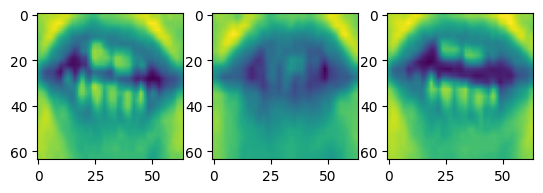

In [35]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(val[0][1][25]) 
axs[1].imshow(val[0][1][35]) 
axs[2].imshow(val[0][1][24]) 
print('Alignments 2. video')
print(val[1][1])

#indeks 0: video, indeks 1: n-ti video iz Batcha, indeks3: vrati n-ti frame(0 do 74)

In [36]:
print('Decoded words for 2. video')
tf.strings.reduce_join([num_to_char(word) for word in val[1][1]])

Decoded words for 2. video


<tf.Tensor: shape=(), dtype=string, numpy=b'place white in x two please'>

# 2. Dizajn Neuralne mreže

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, Dense, GRU, Dropout, Bidirectional, MaxPool3D
from tensorflow.keras.layers import Flatten, Activation, TimeDistributed 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.initializers import Orthogonal

In [38]:
data.as_numpy_iterator().next()[0][0].shape

(75, 64, 64)

In [39]:
# pravimo model koji je najvecim delom CNN - konvoluciona neuralna mreza
# prvi sloj ima shape ulaza(slike) 
# MaxPool3D - male promene u susedsvu ne menjaju rezultat MaxPoolinga, mreza postaje
# robusnija na sum.
# GRU je za nijansu kvalitetniji od LSTM i koristice se kao u original paperu

# bidirectional sluzi da model ima dva GRU sloja, jedan procesiuira recenicu od pocetka do kraja
# drugi sloj procesuira recenicu od kraja do pocetka
# razlog je taj sto u recenicama redosled reci predstavlja vrlo bitan parametar u razumevanju konteksta

In [17]:
model = Sequential()

model.add(Conv3D(128, 3, input_shape=(75, 64, 64, 1), padding='same')) 
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))
print(model.output_shape)

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))
print(model.output_shape)

model.add(Conv3D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))
print(model.output_shape)

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(GRU(128, kernel_initializer=Orthogonal(), return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(GRU(128, kernel_initializer=Orthogonal(), return_sequences=True)))
model.add(Dropout(.5))

#kernel_initializer='he_normal' inicijalizujemo tezine(weights) da odrze kvalitetan gradijent pri obuci
model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))
print(model.output_shape)

NameError: name 'Sequential' is not defined

In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 75, 64, 64, 128)     │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 75, 64, 64, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 75, 32, 32, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 75, 32, 32, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 75, 32, 32, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 75, 16, 16, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 75, 16, 16, 64)      │         442,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 75, 16, 16, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 75, 8, 8, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 75, 4096)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 75, 256)             │       4,326,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 75, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 75, 41)              │          10,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,062,185 (23.13 MB)

 Trainable params: 6,062,185 (23.13 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
#predikcija neistrenirane neuralne mreze
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [43]:
tf.argmax(yhat[0], axis = 1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([26, 26, 30, 15, 15, 15, 15, 15, 15, 30, 30, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15,  1], dtype=int64)>

In [44]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])
#izlaz neistrenirane neuronske mreže

<tf.Tensor: shape=(), dtype=string, numpy=b'zz1oooooo11oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooa'>

In [45]:
model.input_shape

(None, 75, 64, 64, 1)

In [46]:
model.output_shape

(None, 75, 41)

In [47]:
# postavka trening opcija

In [48]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr*tf.math.exp(-0.1)

# Ovaj raspored stope učenja (scheduler) koristi se da bi se održala 
# konstantna stopa učenja tokom prvih 30 epoha treninga.
        
# Nakon 30 epoha, stopa učenja se eksponencijalno smanjuje, što može pomoći modelu 
# da se bolje konvergira i smanji oscilacije oko minimuma funkcije gubitka.

In [49]:
def CTCLoss(y_true, y_pred):
    
    batch_len = tf.cast(tf.shape(y_true)[0], dtype = "int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype = "int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype = "int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype = "int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype = "int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

#https://keras.io/examples/audio/ctc_asr/
# ctc_batch_cost spaja output svakog frejma u smislenu recenicu, primer: ddooooggg -> dog 
# 1. AAA_AAA -> AA 2. AAABBBBB => AB

In [50]:
# klasa koja implementira funkciju on_epoch_end koja vraca sta neuralna mreza prediktuje nakon svake epohe,
# tako da mozemo da pratimo njen napredak in real time

class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original is: ', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction is: ', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [51]:
#koristimo adam optimizer, robustan model optimizacije zasnovan na gradijentu 
# i pogodan za nekonveksnu optimiziacju i problema masinskog ucenja
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = CTCLoss)

In [52]:
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'checkpoint.weights.h5'), monitor = 'loss', save_weights_only = True)

In [53]:
schedule_callback = LearningRateScheduler(scheduler)

In [54]:
example_callback = ProduceExample(data)

In [ ]:
model.fit(data, validation_data = test, epochs = 50, callbacks = [checkpoint_callback, schedule_callback, example_callback])

Epoch 1/50

 23/500 ━━━━━━━━━━━━━━━━━━━━ 1:20:37 10s/step - loss: 172.4822

In [ ]:
#PREDICTIONS

In [18]:
#vec istrenirana mreza sa slicnim parametrima ali posto input i par slojeva nisu isti
#ne daje kvalitetan output

#url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
#output = 'checkpoints.zip'
#gdown.download(url, output, quiet=False)
#gdown.extractall('checkpoints.zip', 'models')

In [84]:
model.load_weights('models/checkpoint.weights.h5')

In [85]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('-'*50, 'GROUND TRUTH TEKST')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]] 

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('-'*50, 'PREDIKTOVANO')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

In [ ]:
#
#
##TEST SA WEBCAMERE ZA DETEKCIJU GOVORA
#
#